### Import Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

### Import Sklearn

In [2]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.datasets import load_iris, load_breast_cancer, load_wine

### Real Datasets

In [3]:
def load_Pendigits_np():
    data = np.loadtxt("./Pendigits/pendigits.tra.txt", delimiter=',')
    pendigits, labels = data[:, :-1], data[:, -1:]

    # Fix pendigits
    pendigits = pendigits.astype("float")
    scaler = MinMaxScaler()
    pendigits = scaler.fit_transform(pendigits)

    # Fix labels
    labels = np.squeeze(labels)
    labels = labels.astype("int")

    return pendigits, labels

def load_iris_np():
    iris = load_iris()
    X = MinMaxScaler().fit_transform(iris.data)
    y = iris.target
    return X, y

def load_wine_np():
    wine = load_wine()
    X = MinMaxScaler().fit_transform(wine.data)
    y = wine.target
    return X, y

def load_breast_cancer_np():
    breast_cancer = load_breast_cancer()
    X = MinMaxScaler().fit_transform(breast_cancer.data)
    y = breast_cancer.target
    return X, y

In [4]:
# Uncomment to select dataset

#X, y = load_iris_np()
#X, y = load_wine_np()
#X, y = load_breast_cancer_np()
#X, y = load_Pendigits_np()

### Synthetic Datasets

In [5]:
def get_artificial2D(path, skiprows):
    full_path = "./Artificial/" + path
    df = pd.read_csv(full_path, skiprows=skiprows, names=['x', 'y', 'class'])
    labels = df["class"].to_numpy()
    label_enc = LabelEncoder()
    labels = label_enc.fit_transform(labels)
    df.drop(columns=["class"], inplace=True)
    data = df.to_numpy()
    
    return data, labels

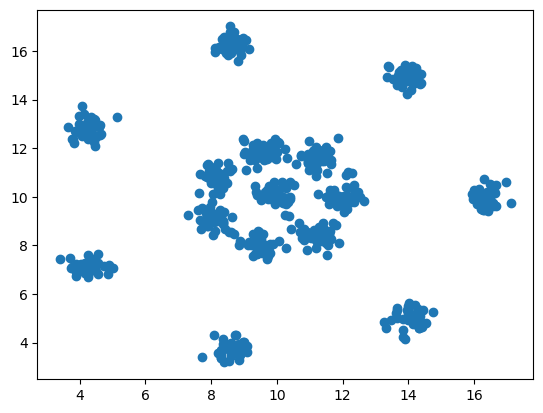

In [6]:
data_details = {
    0:("2d-4c-no4.arff", 10),
    1:("2d-10c.arff", 7),
    2:("aggregation.arff", 12),
    3:("D31.arff", 11),
    4:("impossible.arff", 10),
    5:("R15.arff", 10),
    6:("twenty.arff", 8),
}

# Select synthetic data set
data_id = 5
path, skiprows = data_details[data_id]
X, y = get_artificial2D(path, skiprows)

plt.scatter(X[:,0], X[:,1])
plt.show()

## The global k-means++ method

In [7]:
class Global_Kmeans_pp(BaseEstimator):
    def __init__(self, n_clusters=2, n_candidates=25, sampling='k-means++_batch', max_iter=300, tol=1e-4, verbose=0):
        self.n_clusters = n_clusters
        self.n_candidates = n_candidates
        self.max_iter = max_iter
        self.tol = tol
        self.sampling = sampling
        self.verbose = verbose
        
        self.cluster_centers_ = dict()
        self.cluster_distance_space_ = dict()
        self.inertia_ = dict()
        self.labels_ = dict()
        self.sampled_candidates = dict()
        
    def fit(self, X, y=None):
        kmeans = KMeans(n_clusters=1, init='random', n_init=1, tol=self.tol).fit(X)
        self.n_data = X.shape[0]
        self.cluster_centers_[1] = kmeans.cluster_centers_
        self.cluster_distance_space_[1] = kmeans.transform(X).min(axis=1)
        self.labels_[1] = kmeans.labels_
        self.inertia_[1] = kmeans.inertia_
        
        for k in range(2, self.n_clusters+1):
            if 0 < self.verbose: print('Solving {:d}-means'.format(k))
            centroid_candidates = self.__sampling(X, self.cluster_distance_space_[k-1])
            self.sampled_candidates[k-1] = centroid_candidates
            
            self.inertia_[k] = float('inf')
            for i, xi in enumerate(centroid_candidates): # TODO parallel
                current_centroids = np.vstack((self.cluster_centers_[k-1], xi))
                kmeans = KMeans(n_clusters=k, init=current_centroids, n_init=1, tol=self.tol)
                kmeans = kmeans.fit(X)
                
                if kmeans.inertia_ < self.inertia_[k]:
                    self.cluster_centers_[k] = kmeans.cluster_centers_
                    self.labels_[k] = kmeans.labels_
                    self.inertia_[k] = kmeans.inertia_
                    self.cluster_distance_space_[k] = kmeans.transform(X).min(axis=1)            
        return self
      
    def predict(self, X):
        return self.labels_, self.cluster_centers_, self.inertia_
    
    def transform(self, X):
        return self.cluster_distance_space_
    
    def __sampling(self, X, cluster_distance_space):
        if self.sampling == 'k-means++_batch':
            _, selected_indexes = self.__kmeans_pp_batch(X, cluster_distance_space)
            return X[selected_indexes]
        if self.sampling == 'k-means++_sequential':
            _, selected_indexes = self.__kmeans_pp_sequential(X, cluster_distance_space)
            return X[selected_indexes]
        elif self.sampling == 'global':
            return X
        else:
            print("Wrong sampling method! options = ['k-means++_batch', 'k-means++_sequential', 'global']")
    
    def __kmeans_pp_batch(self, X, cluster_distance_space):
        cluster_distance_space = np.power(cluster_distance_space, 2).flatten()
        sum_distance = np.sum(cluster_distance_space)
        selection_prob = cluster_distance_space / sum_distance
        selected_indexes = np.random.choice(self.n_data, size=self.n_candidates, p=selection_prob, replace=False)
        kmeans_pp_selected_centroids = X[selected_indexes]
        return kmeans_pp_selected_centroids, selected_indexes
    
    def __kmeans_pp_sequential(self, X, cluster_distance_space):
        selected_indexes = np.zeros(shape=(self.n_candidates), dtype=np.int32)       
        cluster_distance_space = cluster_distance_space.flatten()
        for i in range(self.n_candidates):
            cluster_distance_space_squared = np.power(cluster_distance_space, 2)
            sum_distance = np.sum(cluster_distance_space_squared)
            selection_prob = cluster_distance_space_squared / sum_distance
            selected_indexes[i] = np.random.choice(self.n_data, size=1, p=selection_prob, replace=False)
            
            candidate = X[selected_indexes[i]]
            candidate = np.reshape(candidate, newshape=(1, candidate.shape[0]))
            candidate_data_distances = pairwise_distances(candidate, X).flatten()

            # Update probability distribution
            for i, _ in enumerate(cluster_distance_space):
                if candidate_data_distances[i] < cluster_distance_space[i]:
                    cluster_distance_space[i] = candidate_data_distances[i]
                
        kmeans_pp_selected_centroids = X[selected_indexes]
        return kmeans_pp_selected_centroids, selected_indexes

### Global $k$-means++ example

In [21]:
# Select number of clusters K
n_clusters = 16

# Select number of candidates L 
n_candidates = 15

method = {0: 'k-means++_batch', 1: 'k-means++_sequential', 2: 'global'}

# option=0 selects the k-means++ with batch sampling
# option=1 selects the k-means++ with sequential sampling
# option=2 selects the global k-means
option = 1

# Same as in sklearn k-means method
tol = 1e-4
verbose = 1

global_kmeans_pp = Global_Kmeans_pp(n_clusters=n_clusters, n_candidates=n_candidates, sampling=method[option], tol=tol, verbose=verbose)
global_kmeans_pp.fit(X)
clusters, centroids, error = global_kmeans_pp.predict(X)
candidates = global_kmeans_pp.sampled_candidates
error

{1: 12772.997414799998,
 2: 8706.24289362222,
 3: 6051.281885623985,
 4: 4459.295744615506,
 5: 3085.9907364499995,
 6: 2472.3512752499996,
 7: 1871.6997280499997,
 8: 1278.9159470000002,
 9: 796.816875333497,
 10: 498.9932316077639,
 11: 362.28671748074487,
 12: 288.50816616028015,
 13: 221.5160677771992,
 14: 159.74323042098123,
 15: 108.61904081338336,
 16: 105.00295431338337}

### Plot $k$-th clustering solution

In [19]:
color_list = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys())
np.random.shuffle(color_list)
color_list = ['royalblue', 'gold', 'deepskyblue', 'hotpink', 'mediumorchid', 'crimson', 'salmon', 'limegreen'] + color_list

def plot_solution(X, centroids, kmeans_labels, kmeans_centers, candidates):
    # Figure
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.title('{}-means solution'.format(centroids), fontsize=15)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.0)
    
    # Data scatters
    ax.scatter(X[:,0], X[:,1], edgecolors='none', c=[color_list[kmeans_labels[i]] for i in range(kmeans_labels.shape[0])],  s=20)
    ax.scatter(candidates[:,0], candidates[:,1], c='lime', marker='P', s=200, edgecolors='black')
    ax.scatter(kmeans_centers[:,0], kmeans_centers[:,1], c='r', marker='*', s=500, edgecolors='black')

    # Legend
    leg_data = Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='Datapoint', markeredgecolor='black', markersize=10)
    leg_centers = Line2D([0], [0], marker='*', color='w', markerfacecolor='r', label='Center', markeredgecolor='black', markersize=20)
    leg_candidates = Line2D([0], [0], marker='P', color='w', markerfacecolor='lime', label='Candidate', markeredgecolor='black', markersize=15)
    legend = ax.legend(handles=[leg_data, leg_centers, leg_candidates],loc='upper left', fontsize=15)
    
    #legend = ax.legend(['Data', 'Centers', 'Candidates'], loc='upper right', fontsize=13)
    legend.get_frame().set_linewidth(2.0)
    legend.get_frame().set_edgecolor('black')
    legend.legendHandles[0].set_color('w')
    
    # Axes
    #ax.xlim([-0.2, 1.2])
    #ax.ylim([-0.2, 1.2])
    plt.xticks([])
    plt.yticks([]) 
    
    # plt.show()
    plt.tight_layout()
    plt.show()
    plt.close()

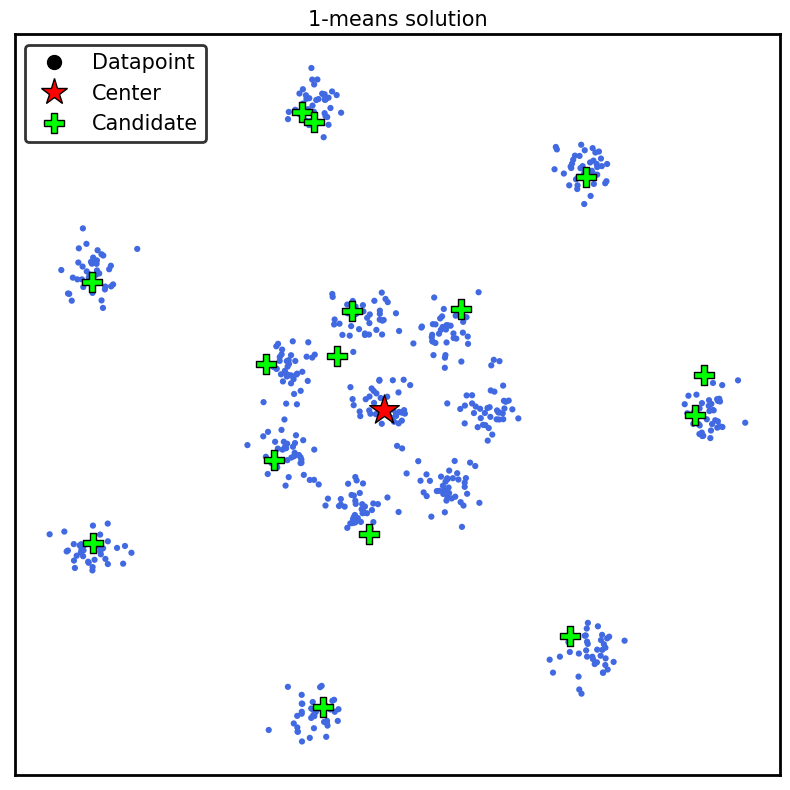

In [20]:
# Select k to plot solution which clustering solution you want to visualize
k = 1
plot_solution(X, "{:d}".format(k), clusters[k], centroids[k], candidates[k])